<h1>IPC Code Evolution</h1>

<a href="https://colab.research.google.com/github/sanjaydasgupta/ipc-code-evolution/blob/master/ipc-evolution-steel-company.ipynb">Run in Google Colaboratory</a>

<h2>1. Imports and other Preliminary Actions</h2>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<h2>2. Load S.11A Data into Pandas DataFrame</h2>

In [2]:
df = pd.read_csv('steel-ipc-dates.csv')

print('Data has %d rows and %d columns' % df.shape)
print('Column names: %s' % ', '.join(df.columns))

Data has 870 rows and 4 columns
Column names: applicationNumber, filingDate, publicationDate, ipc


In [29]:
df.sample(10)

,applicationNumber,filingDate,publicationDate,ipc,ipcs_exploded
631,1046/KOL/2013 A,2013-09-10,2015-03-13,E04C 5/00,"[[E, 04, C, 00005, 00000]]"
842,201631041606 A,2016-12-06,2018-06-08,"B22D 11/00, C21D 8/00","[[B, 22, D, 00011, 00000], [C, 21, D, 00008, 0..."
447,1659/KOL/2008 A,2008-09-25,2012-12-07,C10M 173/00,"[[C, 10, M, 00173, 00000]]"
825,344/KOL/2015 A,2015-03-27,2017-12-08,C04B 18/14,"[[C, 04, B, 00018, 00014]]"
243,201631039505 A,2016-11-19,2018-05-25,C10B 57/00,"[[C, 10, B, 00057, 00000]]"
302,73/KOL/2010 A,2010-01-28,2012-11-16,B22D 11/05,"[[B, 22, D, 00011, 00005]]"
273,237/KOL/2007 A,2007-02-15,2008-08-29,G01N 11/00,"[[G, 01, N, 00011, 00000]]"
693,201831010328 A,2018-03-21,2019-09-27,"C21B 5/00, C21B 7/24","[[C, 21, B, 00005, 00000], [C, 21, B, 00007, 0..."
395,201621041721 A,2016-12-06,2018-06-08,"C25D 5/48, C01B 31/04, B82Y 40/00","[[C, 25, D, 00005, 00048], [C, 01, B, 00031, 0..."
579,1645/KOL/2008 A,2008-09-24,2010-03-26,"F02D 29/06, B60K 6/46, B60P 1/16, B60W 10/30","[[F, 02, D, 00029, 00006], [B, 60, K, 00006, 0..."


<h2>3. Data Cleaning and Enrichment (Wrangling!)</h2>

<h3>3.2 Split IPC-CSVs, Validate and Explode IPC Values</h3>

In [4]:
ipc_regex_pattern = r'\s*'.join([
  '([A-H])', 
  '([0-9]{2})',
  '([A-Z])',
  r'(?:([0-9]{1,5})(?:\s*/?\s*([0-9]{1,5}))?)?'
])

#print(ipc_regex_pattern)
ipc_regex = re.compile(ipc_regex_pattern)

def ipc_explode(ipc):
  m = re.fullmatch(ipc_regex, ipc)
  if m:
    ipc_parts = [e for e in m.groups() if e]
    return ipc_parts[:3] + ['%05d' % int(e) for e in ipc_parts[3:]]
  else:
    return None

def ipc_csv_to_exploded_array(ipc_csv):
  ipc_array = [ipc.strip() for ipc in ipc_csv.split(',')]
  exploded_ipcs = [ipc_explode(ipc) for ipc in ipc_array]
  clean_exploded_ipcs = [e for e in exploded_ipcs if e]
  return clean_exploded_ipcs

df['ipcs_exploded'] = df['ipc'].fillna('').map(ipc_csv_to_exploded_array)

for ipcs in df['ipcs_exploded'].sample(10):
  print(ipcs)

[['G', '01', 'J']]
[['C', '23', 'C', '00014', '00024'], ['F', '16', 'K', '00025', '00000']]
[['C', '22', 'C', '00038', '00000']]
[['C', '21', 'D', '00006', '00000']]
[['B', '22', 'D', '00011', '00005']]
[['B', '29', 'C', '00047', '00000']]
[['G', '01', 'N', '00003', '00048']]
[['C', '09', 'D', '00005', '00008'], ['B', '05', 'D', '00007', '00000'], ['C', '01', 'B', '00031', '00004']]
[['C', '01', 'B', '00032', '00336']]
[['B', '24', 'B', '37013']]


<h3>3.3 Remove Rows with Invalid IPC Data</h3>

In [5]:
df2 = df[df['ipcs_exploded'].map(lambda s: len(s) > 0)].copy()

print(df2.shape)

(867, 5)


<h2><i>5. Feature Engineering</i> -- Convert IPC codes into Text (<i>Sentences</i>)</h2>

Convert the IPC codes into *sentences* to facilitate subsequent processing with scikit-learn's [text-feature-extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) capabilities.

In [6]:
def ipc2sentence(ipc):
    s = ipc[0] if ipc else ''
    if ipc and len(ipc) > 1:
        s += ' ' + ipc[0] + ipc[1]
        if len(ipc) > 2:
            s += ' ' + ipc[0] + ipc[1] + ipc[2]
            if len(ipc) > 3:
                s += ' ' + ipc[0] + ipc[1] + ipc[2] + ipc[3]
                if len(ipc) > 4:
                    s += ' ' + ipc[0] + ipc[1] + ipc[2] + ipc[3] + ipc[4]
    return s

def exploded_ipc_array_to_sentence(ipcs):
    return ' '.join([ipc2sentence(ipc) for ipc in ipcs])

df2['ipcs_sentence'] = df2['ipcs_exploded'].map(exploded_ipc_array_to_sentence)

for ipc_sentence in df2['ipcs_sentence'].sample(10):
    print(ipc_sentence)

C C10 C10B C10B00057 C10B0005700000
C C23 C23C C23C00002 C23C0000200000
B B22 B22D B22D00011 B22D0001100000 C C21 C21D C21D00008 C21D0000800000
B B24 B24B B24B00027 B24B0002700033 C C21 C21D C21D00009 C21D0000900046
C C23 C23C
H H03 H03K H03K00017 H03K0001700000 G G05 G05B G05B00011 G05B0001100000 G G05 G05B G05B00019 G05B0001900000
C C22 C22B C22B00001 C22B0000100020
C C21 C21C C21C00001 C21C0000100000
B B23 B23P
C C08 C08J C08J00005 C08J0000500012


<h3>5.3 Generate Word Counts</h3>

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', tokenizer=str.split, stop_words=[]).fit(df2['ipcs_sentence'])
ipc_vectors = vectorizer.transform(df2['ipcs_sentence'])
print('Rows: %d, Features: %d' % ipc_vectors.shape)
print('Stop words: %s' % vectorizer.stop_words_)

Rows: 867, Features: 1326
Stop words: set()


/home/yajnas/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<h2>6. Prepare Word-Counts for Scatter Plot Display</h2>

<h3>6.1 Use <monospace>TruncatedSVD</monospace> to Reduce to 50 Features</h3>

In [ ]:
#from sklearn.decomposition import TruncatedSVD

#tsvd = TruncatedSVD(n_components=150, random_state=42)
#tsvd100 = tsvd.fit_transform(tf)
#print('Rows: %d, Features: %d' % tsvd100.shape)

<h3>6.2 Use <i>t-SNE</i> to Obtain 2-D (X, Y) Mapping</h3>

In [10]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

tsne = TSNE(n_components=2, n_jobs=-1, random_state=24).fit_transform(ipc_vectors)
print('Rows: %d, Features: %d' % tsne.shape)

tsne_scaled = MinMaxScaler().fit_transform(tsne)

df2['tsne_x'] = tsne_scaled[:, 0]
df2['tsne_y'] = tsne_scaled[:, 1]

display(df2.sample(5))

Rows: 867, Features: 2


,applicationNumber,filingDate,publicationDate,ipc,ipcs_exploded,ipcs_sentence,tsne_x,tsne_y
19,1779/KOL/2008 A,2008-10-21,2010-04-30,"G01L 5/10, G01L 1/26, F16H 7/12, G01L 1/22","[[G, 01, L, 00005, 00010], [G, 01, L, 00001, 0...",G G01 G01L G01L00005 G01L0000500010 G G01 G01L...,0.046516,0.491599
87,201631010477 A,2016-03-28,2017-11-10,C21B 11/10,"[[C, 21, B, 00011, 00010]]",C C21 C21B C21B00011 C21B0001100010,0.824409,0.645650
222,1022/KOL/2015 A,2015-09-28,2017-10-13,B65G 49/00,"[[B, 65, G, 00049, 00000]]",B B65 B65G B65G00049 B65G0004900000,0.651105,0.130849
181,1395/KOL/2008 A,2008-08-19,2015-08-14,C21C 5/00,"[[C, 21, C, 00005, 00000]]",C C21 C21C C21C00005 C21C0000500000,0.946669,0.608107
311,6100/CHENP/2011 A,2011-08-25,2012-11-23,F24D 5/00,"[[F, 24, D, 00005, 00000]]",F F24 F24D F24D00005 F24D0000500000,0.306700,0.362259


<h3>6.3 Scatter-Plot of 2-D Data</h3>

In [11]:
cmap = {'A': 'coral', 'B': 'green', 'C': 'slateblue', 'D': 'cyan', 'E': 'magenta', 'F': 'maroon', 
    'G': 'orange', 'H': 'blue'}

ipc_section_text = {
  'A': 'Human Necessities', 
  'B': 'Performing Ops; Transporting', 
  'C': 'Chemistry; Metallurgy', 
  'D': 'Textiles; Paper', 
  'E': 'Fixed Constructions', 
  'F': 'Mech Engg; Lighting; Heating ...', 
  'G': 'Physics', 
  'H': 'Electricity'
}

In [12]:
from collections import Counter

def decorate(ax, cmap, sizemm, fontsize=14):
  if cmap:
    sections = sorted(list(cmap.keys()))
    #legend_data = [[2 / sizemm, 4 / sizemm, (78 - (i * 3)) / sizemm, section, cmap[section]] for 
    #    i, section in enumerate(sections)]
    legend_data = [[0, 2 / sizemm, (78 - (i * 3)) / sizemm, section, cmap[section]] for 
        i, section in enumerate(sections)]
    legends = pd.DataFrame(legend_data, columns=['x1', 'x2', 'y', 'section', 'color'])
    legends.plot.scatter(ax=ax, x='x1', y='y', color=legends['color'].values, marker='s', s=72, grid=True)
    for legend in legends.values:
      section_text = '%s (%s)' % (legend[3], ipc_section_text[legend[3]])
      ax.text(legend[1], legend[2] - 1 / sizemm, section_text, fontsize=fontsize)

  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_xticklabels(['' for i in range(6)])
  ax.set_yticklabels(['' for i in range(7)])

def ipc_color(df):
  #sections = df['ipcs_sentence'].map(lambda sentence: [word for word in sentence.split() if len(word) == 1])
  sections = df['ipcs_sentence'].map(lambda sentence: [word[0] for word in sentence.split()])
  most_common_section = sections.map(lambda a: Counter(a).most_common(1)[0][0])
  section_colors = most_common_section.map(cmap)
  #section_colors = sections.map(lambda ss: cmap[ss[0]])
  return section_colors.values

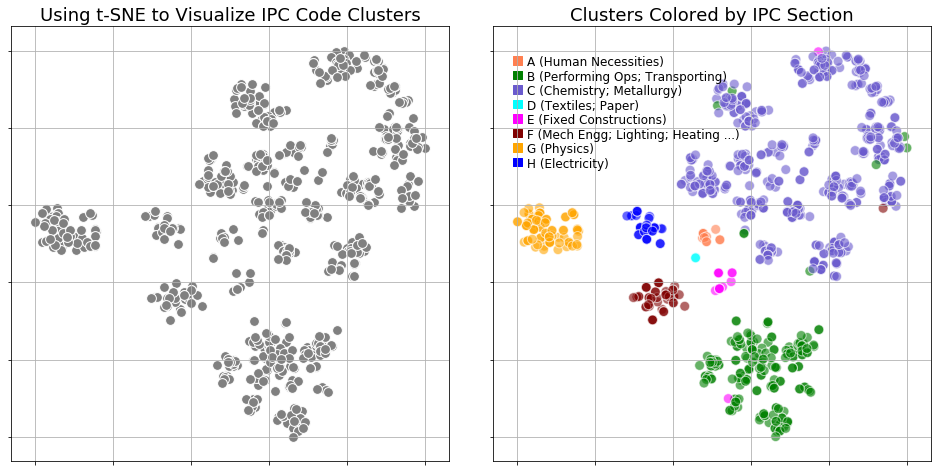

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5, 8))

df2.plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', color='gray', edgecolors='white', s=96, grid=True)
axes[0].set_title('Using t-SNE to Visualize IPC Code Clusters', fontsize=18)
decorate(axes[0], None, None)

#colors = [cmap[section] if section in cmap else 'red' for section in df2['ipcs_sentence'].str[0]]
colors = ipc_color(df2)
df2.plot.scatter(ax=axes[1], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, edgecolors='white', s=96)
axes[1].set_title('Clusters Colored by IPC Section', fontsize=18)
decorate(axes[1], cmap, 80, fontsize=12)

fig.subplots_adjust(wspace=0.1)

None

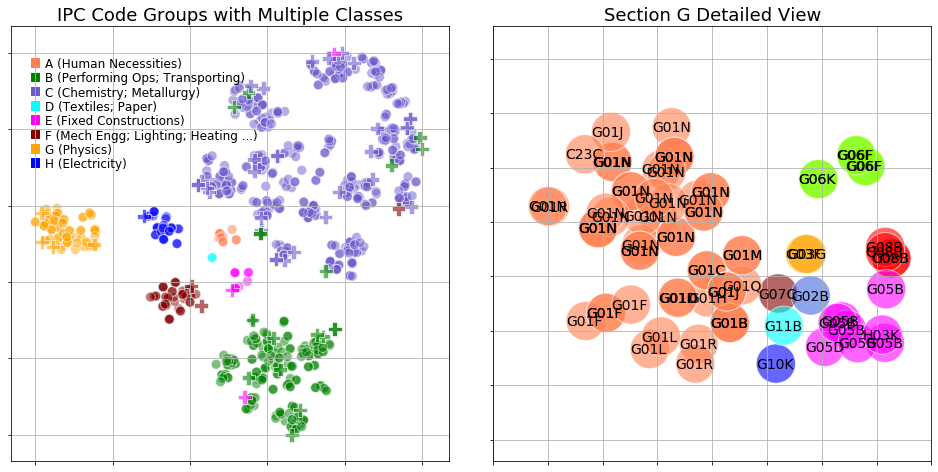

In [19]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16.5, 8))

#
#    First graph
#

one_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) == 1 for ipc3 in df2['ipcs_sentence']]
two_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) == 2 for ipc3 in df2['ipcs_sentence']]
more_ipc = [len(set([ipc[0] for ipc in ipc3.split()])) > 2 for ipc3 in df2['ipcs_sentence']]

#colors = [cmap[section] if section in cmap else 'red' for section in df2[one_ipc]['ipc'].str[0]]
colors = ipc_color(df2[one_ipc])
df2[one_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', 
    alpha=0.5, color=colors, edgecolors='white', s=96, grid=True)

#colors = [cmap[section] if section in cmap else 'red' for section in df2[two_ipc]['ipc'].str[0]]
colors = ipc_color(df2[two_ipc])
df2[two_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, 
    edgecolors='white', marker='P', s=192, grid=True)

#colors = [cmap[section] if section in cmap else 'red' for section in df2[more_ipc]['ipc'].str[0]]
colors = ipc_color(df2[more_ipc])
df2[more_ipc].plot.scatter(ax=axes[0], x='tsne_x', y='tsne_y', alpha=0.6, color=colors, 
    edgecolors='white', marker='X', s=192, grid=True)

decorate(axes[0], cmap, 80, fontsize=12)
axes[0].set_title('IPC Code Groups with Multiple Classes', fontsize=18)

#
#    Second graph
#

dfg = df2.query("tsne_x < 0.2")
axes[1].set_ylim(0.44, 0.64)
axes[1].set_xlim(-0.025, 0.175)
colors = {'G01': 'coral', 'G02': 'royalblue', 'G03': 'orange', 'G04': 'cyan', 'G05': 'magenta', 'G06': 'chartreuse', 
    'G07': 'maroon', 'G08': 'red', 'G10': 'blue', 'G11': 'cyan'}
classes = dfg['ipcs_sentence'].map(lambda sentence: [word[:3] for word in sentence.split() if len(word) >= 3])
most_common_class = classes.map(lambda a: Counter(a).most_common(1)[0][0])
color = [colors[cls] if cls in colors else 'white' for cls in most_common_class]
dfg.plot.scatter(ax=axes[1], x='tsne_x', y='tsne_y', alpha=0.6, color=color, 
    edgecolors='white', s=1536, grid=True)
for row in dfg[['tsne_x', 'tsne_y', 'ipc']].values:
  x, y, ipc = row[0], row[1], row[2]
  colors = {'01': 'red', '02': 'maroon', '03': 'blue', '04': 'cyan', '05': 'magenta', '06': 'green'}
  color = colors[ipc[1:3]] if ipc[1:3] in colors else 'black'
  axes[1].text(x - 0.009, y - 0.002, ipc[0:4], color='black', fontsize=14)
decorate(axes[1], None, None)
axes[1].set_title('Section G Detailed View', fontsize=18)

fig.subplots_adjust(wspace=0.1)

None

In [20]:
from functools import reduce
from operator import add

reduce(lambda s1, s2: s1 | s2, dfg['ipcs_sentence'].map(lambda sentence: set([word for word in sentence.split() if len(word) == 3])).values)

{'C21',
 'C23',
 'F16',
 'G01',
 'G02',
 'G03',
 'G05',
 'G06',
 'G07',
 'G08',
 'G10',
 'G11',
 'H03'}

In [23]:
import matplotlib.pyplot as plt

def twin_charts(year):
  fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5, 8))
  axes = axes.ravel()

  for ax, base_year in zip(axes, [year, year + 2]):

    futuredf = df2.query("publicationDate >= '%d-01-01'" % (base_year + 2))
    futuredf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='white', edgecolors='gray', alpha=0.7, s=96)

    pastdf = df2.query("publicationDate < '%d-01-01'" % base_year)
    pastdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='gray', edgecolors='white', alpha=0.5, s=96)

    currentdf = df2.query("publicationDate >= '%d-01-01' and publicationDate < '%d-01-01'" % (base_year, base_year + 2))
    colors = [cmap[section] if section in cmap else 'red' for section in currentdf['ipc'].str[0]]
    colors = ipc_color(currentdf)
    currentdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color=colors, edgecolors='white', alpha=0.7, s=96)

    ax.set_title('%d and %d' % (base_year, base_year + 1), fontsize=14)
  
    decorate(ax, cmap, 80, fontsize=12)

  fig.subplots_adjust(wspace=0.1, hspace=0.1)

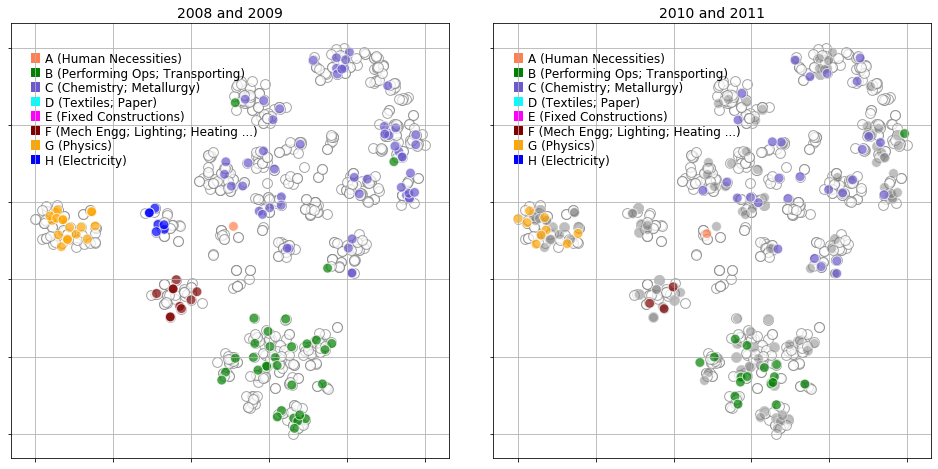

In [24]:
twin_charts(2008)

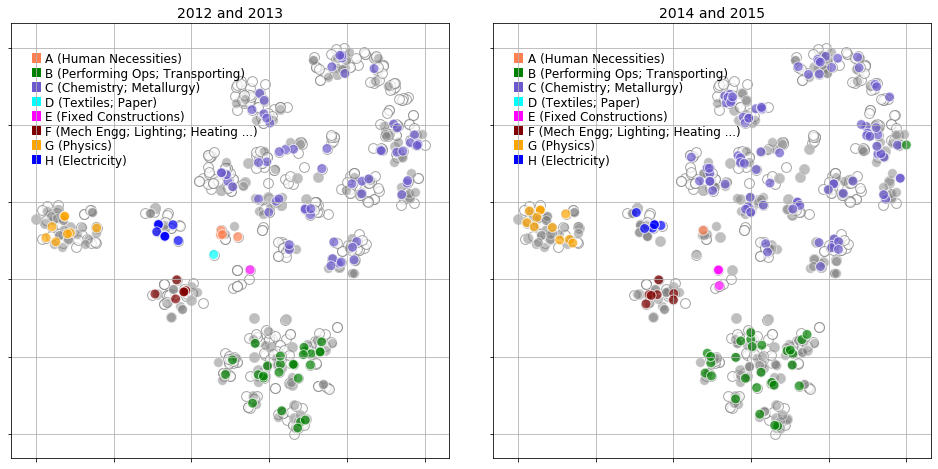

In [25]:
twin_charts(2012)

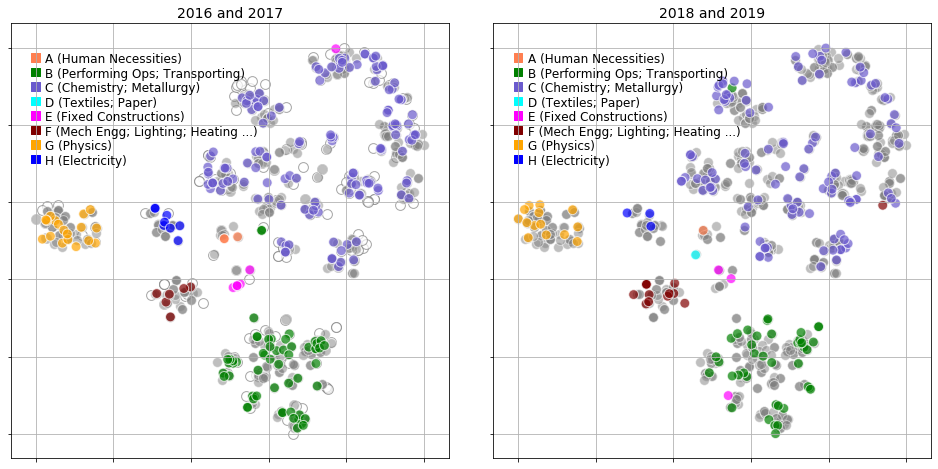

In [26]:
twin_charts(2016)

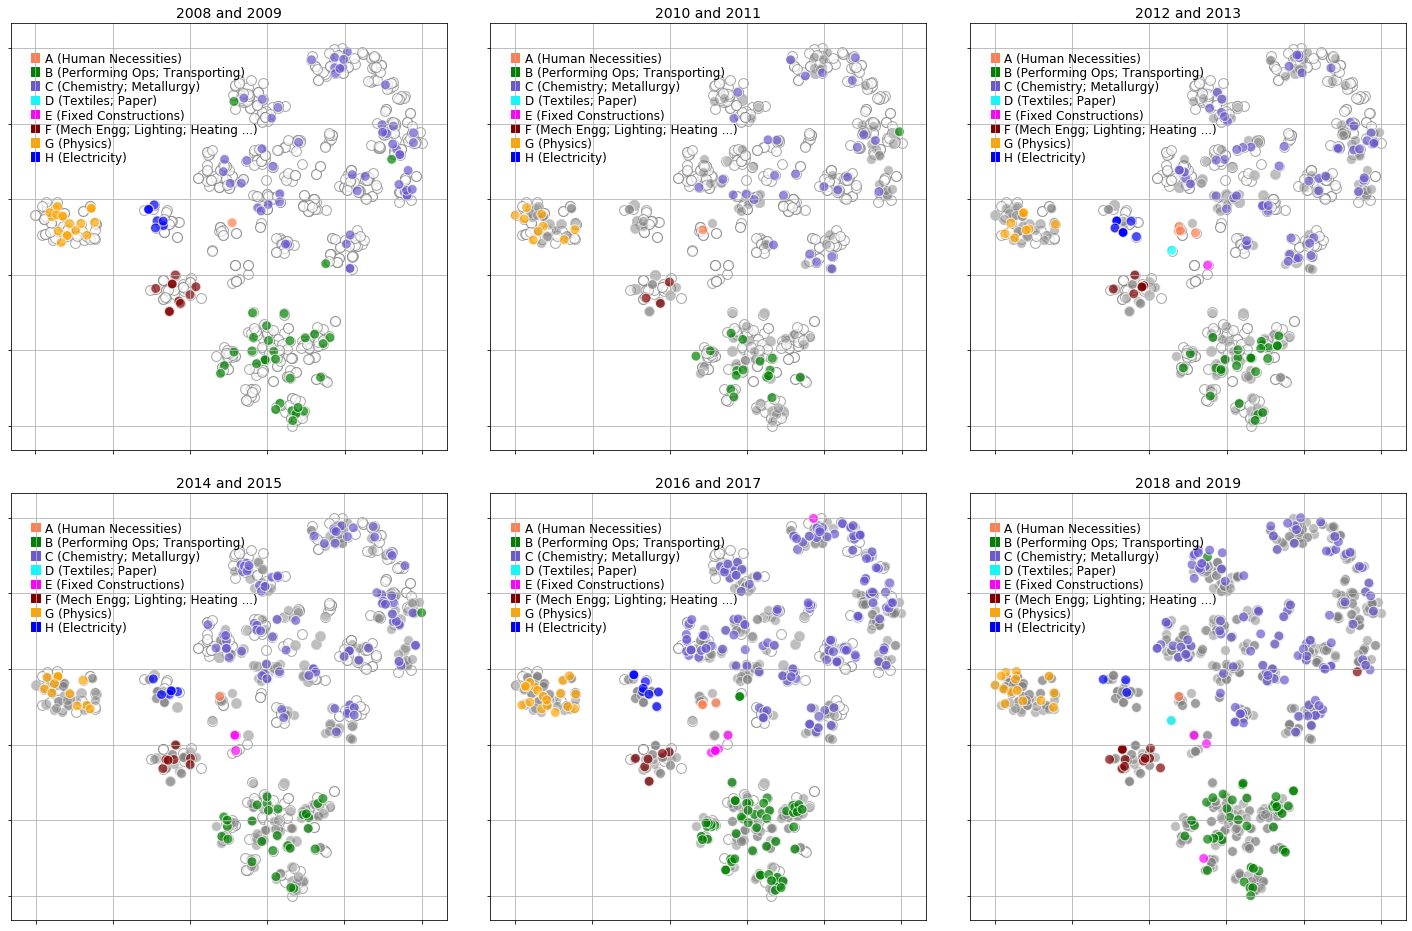

In [28]:
import matplotlib.pyplot as plt

fig, axes23 = plt.subplots(2, 3, sharey=True, figsize=(25, 16.5))
axes = axes23.ravel()

for ax, base_year in zip(axes, range(2008, 2019, 2)):

  futuredf = df2.query("publicationDate >= '%d-01-01'" % (base_year + 2))
  futuredf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='white', edgecolors='gray', alpha=0.7, s=96)

  pastdf = df2.query("publicationDate < '%d-01-01'" % base_year)
  pastdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color='gray', edgecolors='white', alpha=0.5, s=96)

  currentdf = df2.query("publicationDate >= '%d-01-01' and publicationDate < '%d-01-01'" % (base_year, base_year + 2))
  colors = [cmap[section] if section in cmap else 'red' for section in currentdf['ipc'].str[0]]
  colors = ipc_color(currentdf)
  currentdf.plot.scatter(ax=ax, x='tsne_x', y='tsne_y', color=colors, edgecolors='white', alpha=0.7, s=96)

  ax.set_title('%d and %d' % (base_year, base_year + 1), fontsize=14)
  
  decorate(ax, cmap, 80, fontsize=12)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

None